# 2. Vizualizace dat

## Zadání:
V jednom ze cvičení jste probírali práci s moduly pro vizualizaci dat. Mezi nejznámější moduly patří matplotlib (a jeho nadstavby jako seaborn), pillow, opencv, aj. Vyberte si nějakou zajímavou datovou sadu na webovém portále Kaggle a proveďte datovou analýzu datové sady. Využijte k tomu různé typy grafů a interpretujte je (minimálně alespoň 5 zajímavých grafů). Příklad interpretace: z datové sady pro počasí vyplynulo z liniového grafu, že v létě je vyšší rozptyl mezi minimální a maximální hodnotou teploty. Z jiného grafu vyplývá, že v létě je vyšší průměrná vlhkost vzduchu. Důvodem vyššího rozptylu může být absorpce záření vzduchem, který má v létě vyšší tepelnou kapacitu.

## Řešení:


#### Data URL: 
https://www.kaggle.com/datasets/gatandubuc/public-transport-traffic-data-in-france

In [1]:
from matplotlib.pyplot import figure, xlabel, ylabel, plot, subplots
from seaborn import lineplot, barplot, boxplot, stripplot, catplot, heatmap
from calendar import month_name
from pandas import read_csv, DataFrame, concat, pivot
from numpy import array

data = read_csv("Regularities_by_liaisons_Trains_France.csv")
hdi = data.sort_values(["Year", "Month"]).groupby(["Year", "Month"]).sum()

detarture_delay_by_years = hdi.groupby("Year")["Number of late trains at departure"].sum()
departure_and_arrival_delays_by_months = hdi.groupby("Month")[["Number of late trains at departure", "Number of trains late on arrival"]].sum()
departure_delays_by_months = departure_and_arrival_delays_by_months["Number of late trains at departure"];

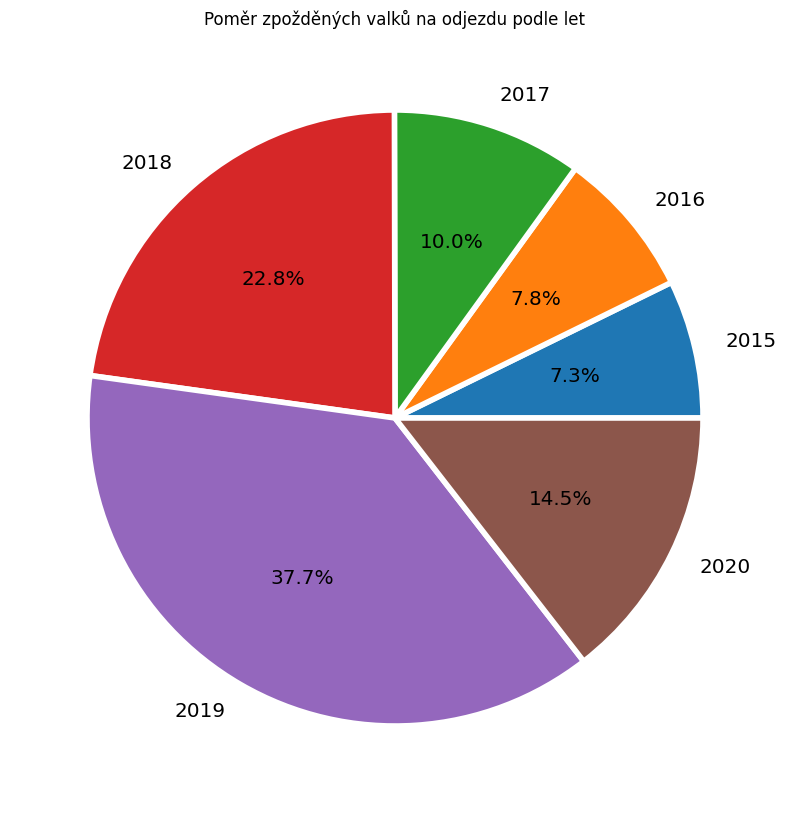

In [2]:
fig, ax = subplots(figsize=(10, 10))
ax.set_title("Poměr zpožděných valků na odjezdu podle let")
ax.pie(
    detarture_delay_by_years, 
    labels=list(map(str, detarture_delay_by_years.index)), 
    autopct='%.1f%%', 
    wedgeprops={'linewidth': 4.0, 'edgecolor': 'white'}, 
    textprops={'size': 'x-large'},
);

Z tohoto grafu můžeme pozorovat, že největší zpoždění vlaků bylo v letech 2018 a 1019 a že v těchto letech buď byla více využívaná veřejná doprava nebo třeba byly větší opravy, kde vznikala zpoždění a nebo obojí.

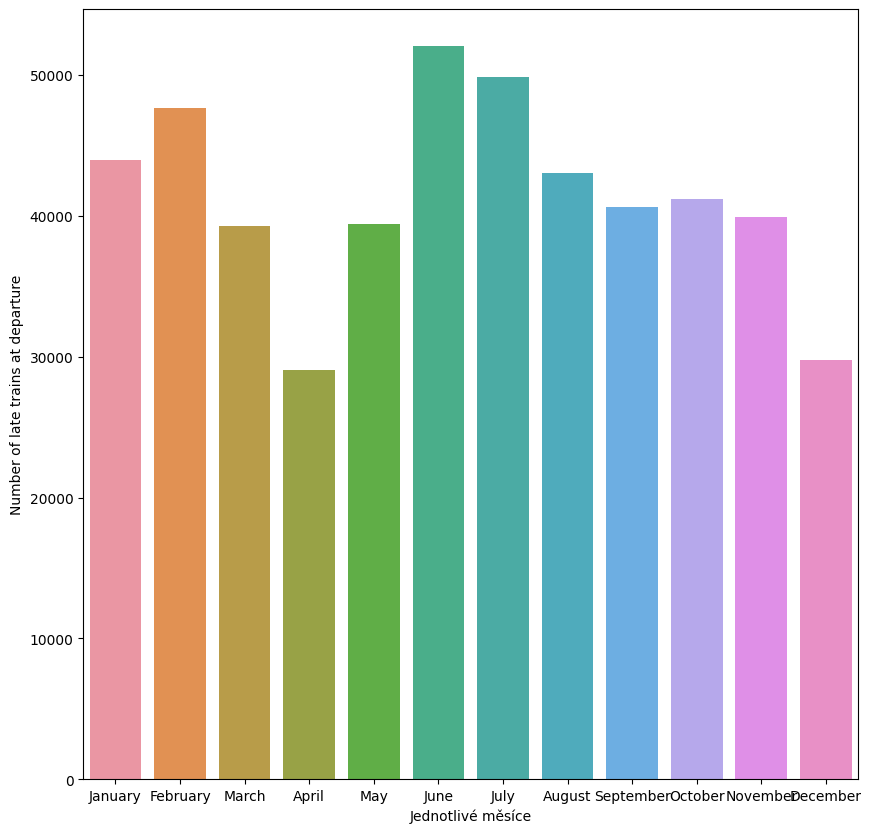

In [3]:
fig, ax = subplots(figsize=(10, 10))
ax.set_xlabel("Jednotlivé měsíce")
ax.set_ylabel("Součet opožděných vlaků v danných měsících")
month_labels = [ month_name[int(idx)] for idx in departure_delays_by_months.index ]
barplot(y = departure_delays_by_months, x = month_labels);

Z tohoto garfu zase můžeme vyčíst, že obecne vlaky nabývali zpoždění nejvíce v Červnu a zároveň nejméně v Dubnu a v prosinci.

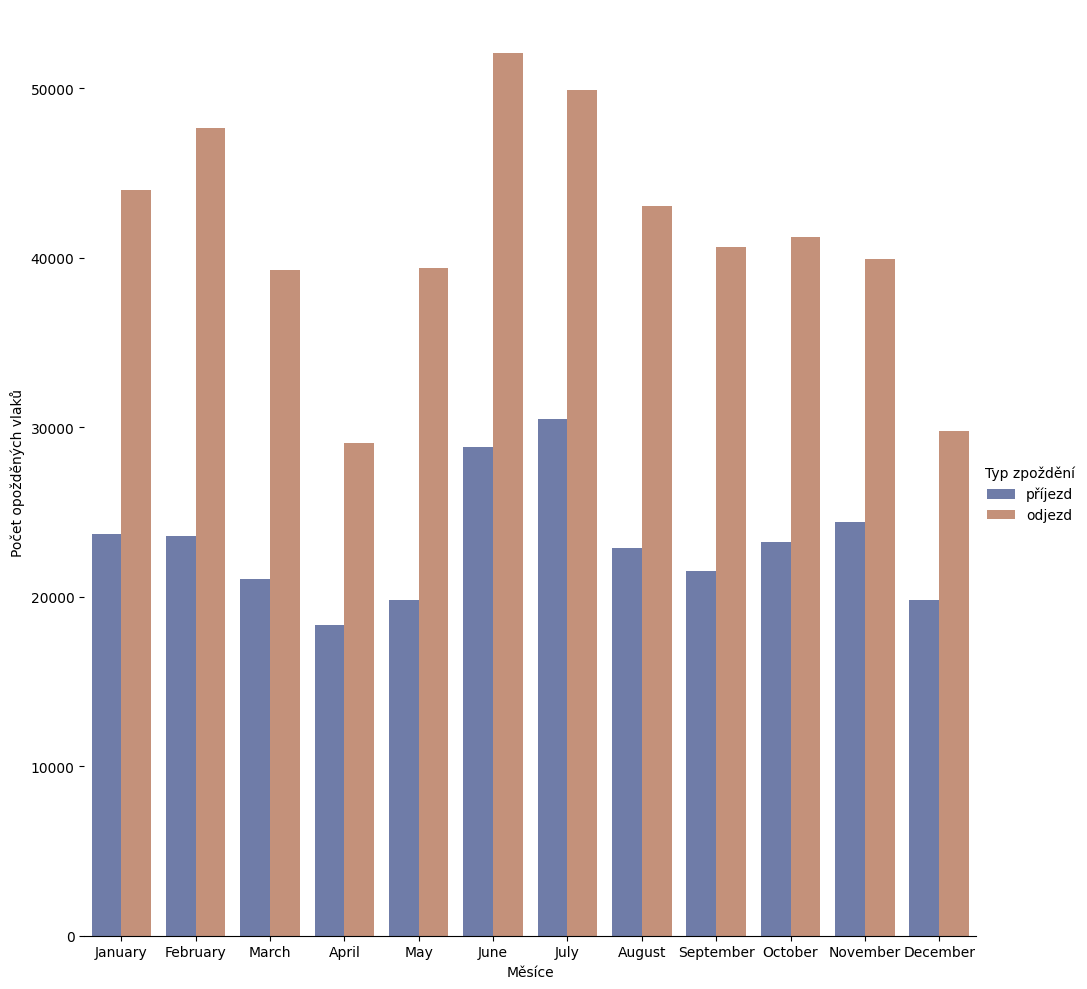

In [4]:
month_labels = [ month_name[int(mi)] for mi in departure_and_arrival_delays_by_months.index ]

arrivals = DataFrame([
    month_labels,
    departure_and_arrival_delays_by_months["Number of trains late on arrival"],
    ["příjezd" for _ in range(len(departure_and_arrival_delays_by_months))]
]).transpose()

departures = DataFrame([
    month_labels,
    departure_and_arrival_delays_by_months["Number of late trains at departure"],
    ["odjezd" for _ in range(len(departure_and_arrival_delays_by_months))]
]).transpose()

transformed_departures_and_delays = concat([arrivals, departures])
transformed_departures_and_delays.columns = ("Month", "Number of late trains", "Type")

g = catplot(
    data=transformed_departures_and_delays, 
    kind="bar",
    x="Month", 
    y="Number of late trains", 
    hue="Type",
    errorbar="sd", 
    palette="dark", 
    alpha=.6, 
    height=10
)
g.despine(left=True)
g.set_axis_labels("Měsíce", "Počet opožděných vlaků")
g.legend.set_title("Typ zpoždění");

Zde můžeme pozorovat celkové rozdíly mezi zpožděním na příjedu a na odjezdu na jednotlivích měsících

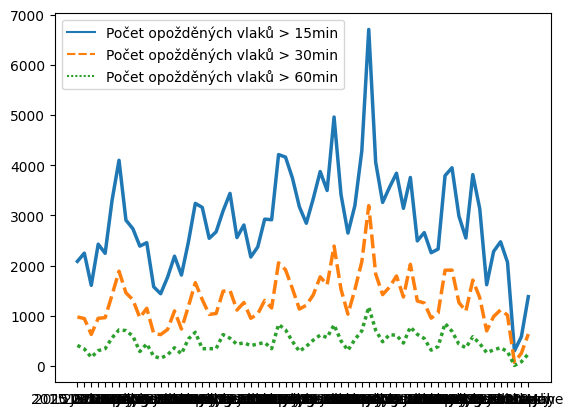

In [5]:
individual_timed_delay_keys = [
    "Number of late trains > 15min",
    "Number of late trains > 30min",
    "Number of late trains > 60min"
]

individual_timed_delay_names = [
    "Počet opožděných vlaků > 15min",
    "Počet opožděných vlaků > 30min",
    "Počet opožděných vlaků > 60min"
]

delays = hdi[individual_timed_delay_keys]
# delays.columns = individual_timed_delay_names

df = DataFrame(array(delays), list(map(lambda date: f'{date[0]} {month_name[int(date[1])]}', delays.index)), columns = individual_timed_delay_names)

lineplot(data=df, palette="tab10", linewidth=2.5);

Tenhle graf nám znázorňuje kolik vlaků mělo zpoždění větší jak 15 minut, 30 minut a kolik jich mělo hodinu.

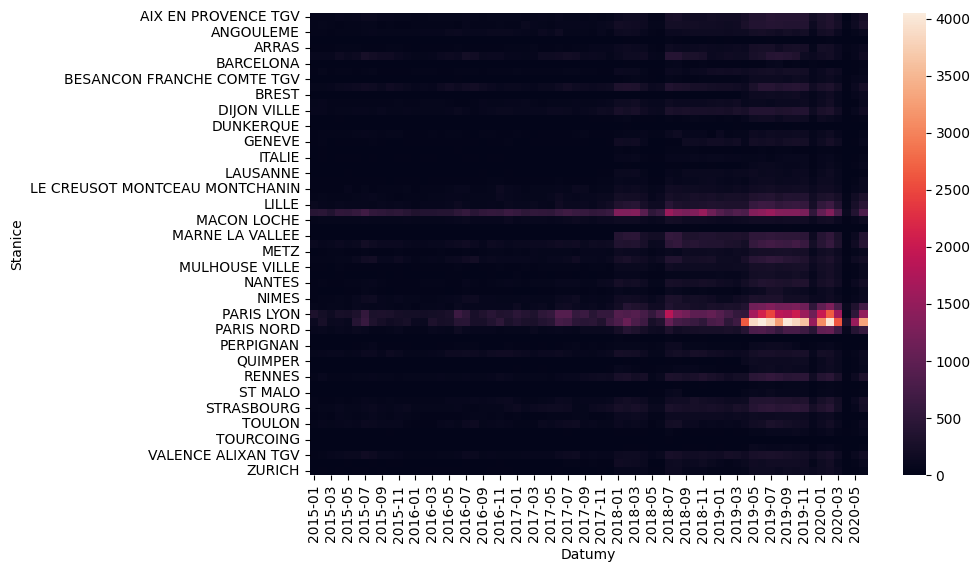

In [6]:
filtered_data = data.groupby(["Departure station", "Period"])["Number of late trains at departure"].sum()

df2 = DataFrame([
    list(filtered_data),
    list(map(lambda x: x[0], filtered_data.index)),
    list(map(lambda x: x[1], filtered_data.index)),
]).transpose()
df2.columns = ["data", "station", "period"]

f, ax = subplots(figsize=(9, 6))

a = df2.pivot(index='station', columns='period', values='data').fillna(0)

hm = heatmap(a)
hm.set(xlabel='Datumy', ylabel='Stanice');


A z tohohle grafu můžeme vyčít v jakých stanicích měli vlaky při odjezdu největší zpoždění